In [2]:
import os

# Data Manipulation
import pandas as pd
import numpy as np
from pandas.io.stata import StataReader

# Visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics
from scipy import stats
import statsmodels.formula.api as sm


# Profiling
import ydata_profiling as yp

# para a análise de dados espaciais
import geopandas as gp
import pysal as ps
import splot
import mapclassify as mc
# from libpysal.weights import Queen
# from libpysal import weights
# from esda import Moran, Moran_Local, G_Local
# from splot.esda import plot_moran, moran_scatterplot, lisa_cluster, plot_local_autocorrelation

# 1. Reading the data

In [3]:
# Read the file and the labels
with StataReader('../stata/amostra_domicilios_2010_RJ.dta') as reader:
    data_micro = reader.read(convert_categoricals=False)
    col_labels = reader.variable_labels()
    value_labels = reader.value_labels()

# Remove '_lbl' from the keys in value_labels
value_labels = {k.replace('_lbl', ''): v for k, v in value_labels.items()}

# Apply the labels to the data
for col, labels in value_labels.items():
    if col in data_micro:
        data_micro[col] = data_micro[col].map(labels)

# Apply the labels to the columns
data_micro = data_micro.rename(columns=col_labels)

# Convert ÁREA DE PONDERAÇÃO to int64
data_micro['ÁREA DE PONDERAÇÃO'] = data_micro['ÁREA DE PONDERAÇÃO'].astype('int64')
# Transform the column to string, remove the 8th character and convert back to int64
# This is done to make the column joinable with CD_GEOCODB from the SHP data
data_micro['ÁREA DE PONDERAÇÃO'] = data_micro['ÁREA DE PONDERAÇÃO'].astype(str).apply(lambda x: x[:7] + x[8:]).astype('int64')


filtra apenas os dados do RJ

In [4]:
df_rio = data_micro[data_micro['CÓDIGO DO MUNICÍPIO'] == 'Rio de Janeiro']
df_rio.info()
df_rio.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104712 entries, 196547 to 301258
Data columns (total 76 columns):
 #   Column                                                                            Non-Null Count   Dtype  
---  ------                                                                            --------------   -----  
 0   UNIDADE DA FEDERAÇÃO                                                              104712 non-null  object 
 1   CÓDIGO DO MUNICÍPIO                                                               104712 non-null  object 
 2   ÁREA DE PONDERAÇÃO                                                                104712 non-null  int64  
 3   CONTROLE                                                                          104712 non-null  float64
 4   PESO AMOSTRAL                                                                     104712 non-null  float64
 5   REGIÃO GEOGRÁFICA                                                                 104712 non-nu

,UNIDADE DA FEDERAÇÃO,CÓDIGO DO MUNICÍPIO,ÁREA DE PONDERAÇÃO,CONTROLE,PESO AMOSTRAL,REGIÃO GEOGRÁFICA,CÓDIGO DA MESORREGIÃO,CÓDIGO DA MICRORREGIÃO,CÓDIGO DA REGIÃO METROPOLITANA,SITUAÇÃO DO DOMICÍLIO,...,MARCA DE IMPUTAÇÃO NA V0218,MARCA DE IMPUTAÇÃO NA V0219,MARCA DE IMPUTAÇÃO NA V0220,MARCA DE IMPUTAÇÃO NA V0221,MARCA DE IMPUTAÇÃO NA V0222,MARCA DE IMPUTAÇÃO NA V0301,MARCA DE IMPUTAÇÃO NA V0401,MARCA DE IMPUTAÇÃO NA V0402,MARCA DE IMPUTAÇÃO NA V0701,Situação do setor
196547,Rio de Janeiro,Rio de Janeiro,330455705001,2171.0,1.824236e+14,Região sudeste (uf=31 a 33 e 35),Metropolitana do Rio de Janeiro,Rio de Janeiro,19,Urbana,...,Não,Não,Não,Não,Não,Não,Não,Não,Não,Área urbanizada
196548,Rio de Janeiro,Rio de Janeiro,330455705001,11523.0,2.207511e+14,Região sudeste (uf=31 a 33 e 35),Metropolitana do Rio de Janeiro,Rio de Janeiro,19,Urbana,...,Não,Não,Não,Não,Não,Não,Não,Não,Não,Área urbanizada
196549,Rio de Janeiro,Rio de Janeiro,330455705001,13794.0,1.441748e+14,Região sudeste (uf=31 a 33 e 35),Metropolitana do Rio de Janeiro,Rio de Janeiro,19,Urbana,...,Não,Não,Não,Não,Não,Não,Não,Não,Não,Área urbanizada
196550,Rio de Janeiro,Rio de Janeiro,330455705001,22268.0,1.832662e+14,Região sudeste (uf=31 a 33 e 35),Metropolitana do Rio de Janeiro,Rio de Janeiro,19,Urbana,...,Não,Não,Não,Não,Não,Não,Não,Sim,Não,Área urbanizada
196551,Rio de Janeiro,Rio de Janeiro,330455705001,37328.0,1.783257e+14,Região sudeste (uf=31 a 33 e 35),Metropolitana do Rio de Janeiro,Rio de Janeiro,19,Urbana,...,Não,Não,Não,Não,Não,Não,Não,Sim,Não,Área urbanizada


# 2. Importando SHP

In [5]:
# Read the shapefile
gdf = gp.read_file('shp/rj_setores_censitarios/33SEE250GC_SIR.shp')

# Filter the data to only the city of Rio de Janeiro
gdf_rio = gdf[gdf['NM_MUNICIP'] == 'RIO DE JANEIRO']
gdf_rio.head()

# Select the column with the code of the area and the geometry
selected_columns = ['CD_GEOCODB', 'NM_BAIRRO', 'geometry']
gdf_rio = gdf_rio[selected_columns]
gdf_rio['CD_GEOCODB'] = gdf_rio['CD_GEOCODB'].astype('int64')

gdf_rio.info()
gdf_rio.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 10504 entries, 10708 to 23328
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   CD_GEOCODB  10504 non-null  int64   
 1   NM_BAIRRO   10504 non-null  object  
 2   geometry    10504 non-null  geometry
dtypes: geometry(1), int64(1), object(1)
memory usage: 328.2+ KB


,CD_GEOCODB,NM_BAIRRO,geometry
10708,330455705005,Catumbi,"POLYGON ((-43.19949 -22.92454, -43.19953 -22.9..."
10709,330455705005,Catumbi,"POLYGON ((-43.19795 -22.91829, -43.19819 -22.9..."
10710,330455705005,Catumbi,"POLYGON ((-43.19858 -22.91876, -43.19888 -22.9..."
10711,330455705005,Catumbi,"POLYGON ((-43.19879 -22.91937, -43.19879 -22.9..."
10712,330455705005,Catumbi,"POLYGON ((-43.19791 -22.92028, -43.19791 -22.9..."


## 2.1. Juntando os datasets

In [6]:
df_rio_join = df_rio.merge(gdf_rio, left_on='ÁREA DE PONDERAÇÃO', right_on='CD_GEOCODB', how='inner')

In [7]:
df_rio_join.head()

,UNIDADE DA FEDERAÇÃO,CÓDIGO DO MUNICÍPIO,ÁREA DE PONDERAÇÃO,CONTROLE,PESO AMOSTRAL,REGIÃO GEOGRÁFICA,CÓDIGO DA MESORREGIÃO,CÓDIGO DA MICRORREGIÃO,CÓDIGO DA REGIÃO METROPOLITANA,SITUAÇÃO DO DOMICÍLIO,...,MARCA DE IMPUTAÇÃO NA V0221,MARCA DE IMPUTAÇÃO NA V0222,MARCA DE IMPUTAÇÃO NA V0301,MARCA DE IMPUTAÇÃO NA V0401,MARCA DE IMPUTAÇÃO NA V0402,MARCA DE IMPUTAÇÃO NA V0701,Situação do setor,CD_GEOCODB,NM_BAIRRO,geometry
0,Rio de Janeiro,Rio de Janeiro,330455705001,2171.0,1.824236e+14,Região sudeste (uf=31 a 33 e 35),Metropolitana do Rio de Janeiro,Rio de Janeiro,19,Urbana,...,Não,Não,Não,Não,Não,Não,Área urbanizada,330455705001,Centro,"POLYGON ((-43.19734 -22.90729, -43.19833 -22.9..."
1,Rio de Janeiro,Rio de Janeiro,330455705001,2171.0,1.824236e+14,Região sudeste (uf=31 a 33 e 35),Metropolitana do Rio de Janeiro,Rio de Janeiro,19,Urbana,...,Não,Não,Não,Não,Não,Não,Área urbanizada,330455705001,Centro,"POLYGON ((-43.19133 -22.90252, -43.19178 -22.9..."
2,Rio de Janeiro,Rio de Janeiro,330455705001,2171.0,1.824236e+14,Região sudeste (uf=31 a 33 e 35),Metropolitana do Rio de Janeiro,Rio de Janeiro,19,Urbana,...,Não,Não,Não,Não,Não,Não,Área urbanizada,330455705001,Centro,"POLYGON ((-43.18819 -22.90429, -43.18836 -22.9..."
3,Rio de Janeiro,Rio de Janeiro,330455705001,2171.0,1.824236e+14,Região sudeste (uf=31 a 33 e 35),Metropolitana do Rio de Janeiro,Rio de Janeiro,19,Urbana,...,Não,Não,Não,Não,Não,Não,Área urbanizada,330455705001,Centro,"POLYGON ((-43.18474 -22.90199, -43.18591 -22.9..."
4,Rio de Janeiro,Rio de Janeiro,330455705001,2171.0,1.824236e+14,Região sudeste (uf=31 a 33 e 35),Metropolitana do Rio de Janeiro,Rio de Janeiro,19,Urbana,...,Não,Não,Não,Não,Não,Não,Área urbanizada,330455705001,Centro,"MULTIPOLYGON (((-43.18324 -22.90254, -43.18343..."


## 2.2. Agregando o dataset por bairro

In [59]:
# Select only numeric columns
numeric_cols = df_rio_join.select_dtypes(include=np.number).columns.tolist()

# Remove 'PESO AMOSTRAL' from the list of columns to group
numeric_cols.remove('PESO AMOSTRAL')

# Define a function to calculate the weighted average
def weighted_avg(group, avg_name, weight_name):
    """ Calculate weighted avg """
    return np.average(group[avg_name], weights=group[weight_name])

# Group the DataFrame and calculate the weighted average
df_rio_join_no_na = df_rio_join.dropna(subset=numeric_cols)
df_rio_bairros = df_rio_join_no_na.groupby('ÁREA DE PONDERAÇÃO').apply(lambda g: pd.Series({col: weighted_avg(g, col, 'PESO AMOSTRAL') for col in numeric_cols}))

# drop some columns that are not needed
drop_cols = ['ÁREA DE PONDERAÇÃO', 'CONTROLE', 'CÓDIGO DA REGIÃO METROPOLITANA', 'CD_GEOCODB']
df_rio_bairros = df_rio_bairros.drop(drop_cols, axis=1)

# Join to get the name of the neighborhood
df_rio_bairros = df_rio_join[['ÁREA DE PONDERAÇÃO', 'NM_BAIRRO', 'geometry']].merge(df_rio_bairros, left_on='ÁREA DE PONDERAÇÃO', right_index=True, how='right')
# drop duplicates generated by the join
df_rio_bairros = df_rio_bairros.drop_duplicates()

# convert to geodataframe
gdf_rio_bairros = gp.GeoDataFrame(df_rio_bairros, geometry='geometry')

In [47]:
df_rio_bairros.info()
df_rio_bairros.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10504 entries, 0 to 5468162
Data columns (total 14 columns):
 #   Column                                                                          Non-Null Count  Dtype   
---  ------                                                                          --------------  -----   
 0   ÁREA DE PONDERAÇÃO                                                              10504 non-null  int64   
 1   NM_BAIRRO                                                                       10504 non-null  object  
 2   geometry                                                                        10504 non-null  geometry
 3   VALOR DO ALUGUEL (EM REAIS)                                                     10504 non-null  float64 
 4   ALUGUEL EM Nº DE SALÁRIOS MÍNIMOS                                               10504 non-null  float64 
 5   CÔMODOS, NÚMERO                                                                 10504 non-null  float64 
 6   DENS

,ÁREA DE PONDERAÇÃO,NM_BAIRRO,geometry,VALOR DO ALUGUEL (EM REAIS),ALUGUEL EM Nº DE SALÁRIOS MÍNIMOS,"CÔMODOS, NÚMERO",DENSIDADE DE MORADOR/CÔMODO,"CÔMODOS COMO DORMITÓRIO, NÚMERO",DENSIDADE DE MORADOR / DORMITÓRIO,QUANTAS PESSOAS MORAVAM NESTE DOMICÍLIO EM 31 DE JULHO DE 2010,RENDIMENTO MENSAL DOMICILIAR EM JULHO DE 2010,"RENDIMENTO DOMICILIAR, SALÁRIOS MÍNIMOS, EM JULHO DE 2010",RENDIMENTO DOMICILIAR PER CAPITA EM JULHO DE 2010,"RENDIMENTO DOMICILIAR PER CAPITA, EM Nº DE SALÁRIOS MÍNIMOS, EM JULHO DE 2010"
0,330455705001,Centro,"POLYGON ((-43.19734 -22.90729, -43.19833 -22.9...",327.799218,64274.442757,4.043308,7.986894,1.497733,21.319577,2.922845,1579.880703,309780.49048,61849.65997,121273.835187
1,330455705001,Centro,"POLYGON ((-43.19133 -22.90252, -43.19178 -22.9...",327.799218,64274.442757,4.043308,7.986894,1.497733,21.319577,2.922845,1579.880703,309780.49048,61849.65997,121273.835187
2,330455705001,Centro,"POLYGON ((-43.18819 -22.90429, -43.18836 -22.9...",327.799218,64274.442757,4.043308,7.986894,1.497733,21.319577,2.922845,1579.880703,309780.49048,61849.65997,121273.835187
3,330455705001,Centro,"POLYGON ((-43.18474 -22.90199, -43.18591 -22.9...",327.799218,64274.442757,4.043308,7.986894,1.497733,21.319577,2.922845,1579.880703,309780.49048,61849.65997,121273.835187
4,330455705001,Centro,"MULTIPOLYGON (((-43.18324 -22.90254, -43.18343...",327.799218,64274.442757,4.043308,7.986894,1.497733,21.319577,2.922845,1579.880703,309780.49048,61849.65997,121273.835187


# 3. Plotando o mapa

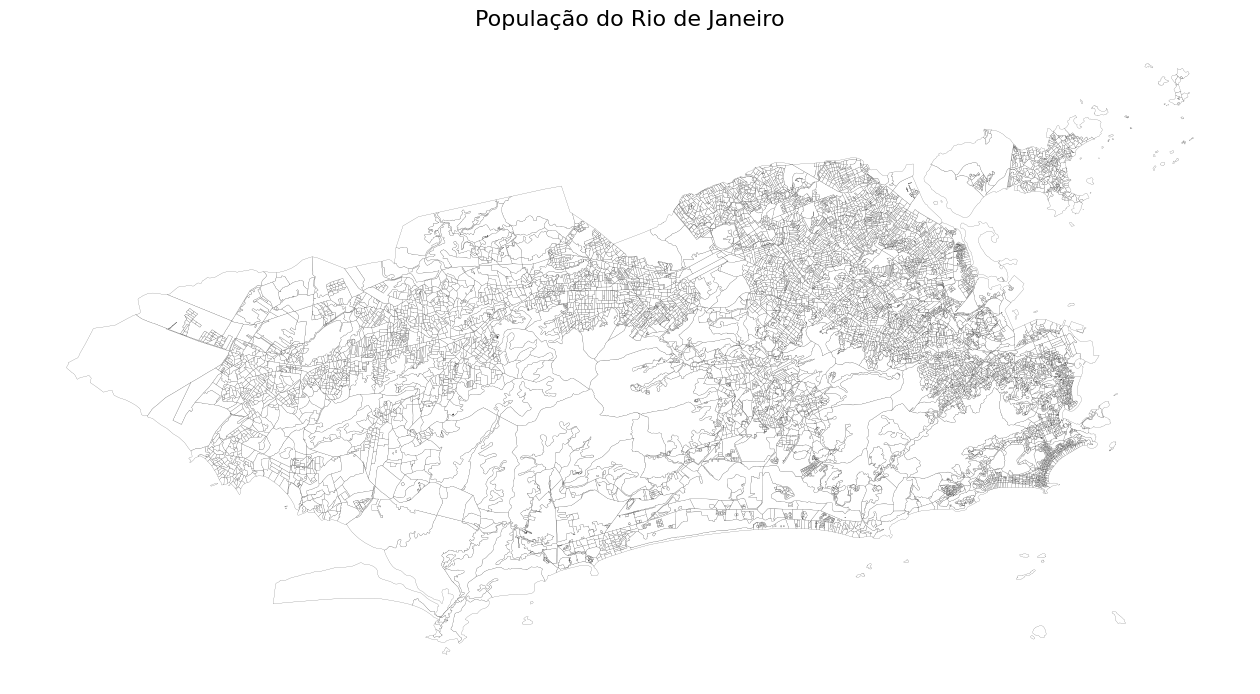

In [ ]:
def plot_city(gdf, df, column, title, cmap='viridis', figsize=(16, 10)):
    fig, ax = plt.subplots(1, figsize=figsize)
    gdf.plot(ax=ax, color='white', edgecolor='black', linewidth=0.1)
    # df.plot(ax=ax, column=column, cmap=cmap, legend=True)
    ax.set_title(title, fontsize=16)
    ax.set_axis_off()
    plt.show()

plot_city(gdf_rio, df_rio, 'V002', 'População do Rio de Janeiro')

# ax = gdf_rio.plot(figsize=(12, 12), alpha=0.5, edgecolor='k');

# for i in gdf_rio.index:
#     plt.text(gdf_rio.geometry.centroid[i].coords[0][0], gdf_rio.geometry.centroid[i].coords[0][1], gdf_rio.NM_BAIRRO[i],
#              fontsize=10, horizontalalignment='center', verticalalignment='center');

# ax.set_axis_off();

C:\Users\gianl\AppData\Local\Temp\ipykernel_18652\3481444330.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  plt.text(gdf_rio.geometry.centroid[i].coords[0][0], gdf_rio.geometry.centroid[i].coords[0][1], gdf_rio.NM_BAIRRO[i],


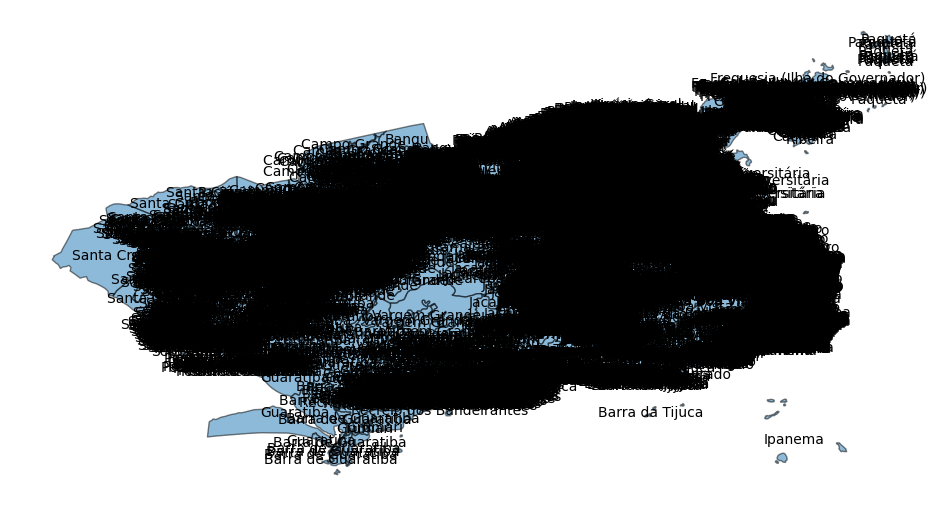

In [ ]:
ax = gdf_rio.plot(figsize=(12, 12), alpha=0.5, edgecolor='k');

for i in gdf_rio.index:
    plt.text(gdf_rio.geometry.centroid[i].coords[0][0], gdf_rio.geometry.centroid[i].coords[0][1], gdf_rio.NM_BAIRRO[i],
             fontsize=10, horizontalalignment='center', verticalalignment='center');

ax.set_axis_off();

C:\Users\gianl\AppData\Local\Temp\ipykernel_13804\3738927575.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_rio_unique.geometry.centroid[i].coords[0][0],
C:\Users\gianl\AppData\Local\Temp\ipykernel_13804\3738927575.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_rio_unique.geometry.centroid[i].coords[0][1],


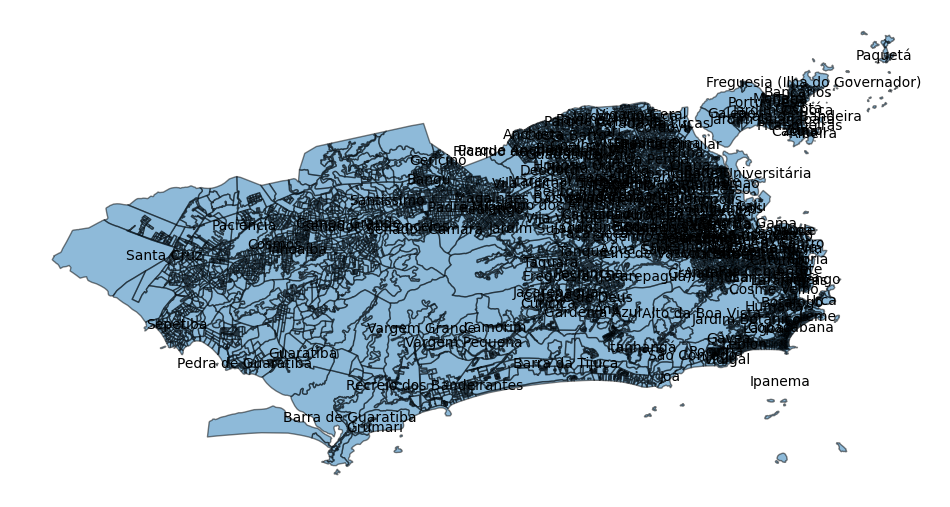

In [10]:
# Create a new GeoDataFrame with the centroid of each unique NM_BAIRRO
gdf_rio_unique = gdf_rio.dissolve(by='NM_BAIRRO', aggfunc='first').reset_index()

ax = gdf_rio.plot(figsize=(12, 12), alpha=0.5, edgecolor='k')

for i in gdf_rio_unique.index:
    plt.text(
        gdf_rio_unique.geometry.centroid[i].coords[0][0], 
        gdf_rio_unique.geometry.centroid[i].coords[0][1], 
        gdf_rio_unique.NM_BAIRRO[i],
        fontsize=10, 
        horizontalalignment='center', 
        verticalalignment='center'
    )

ax.set_axis_off();
plt.show()

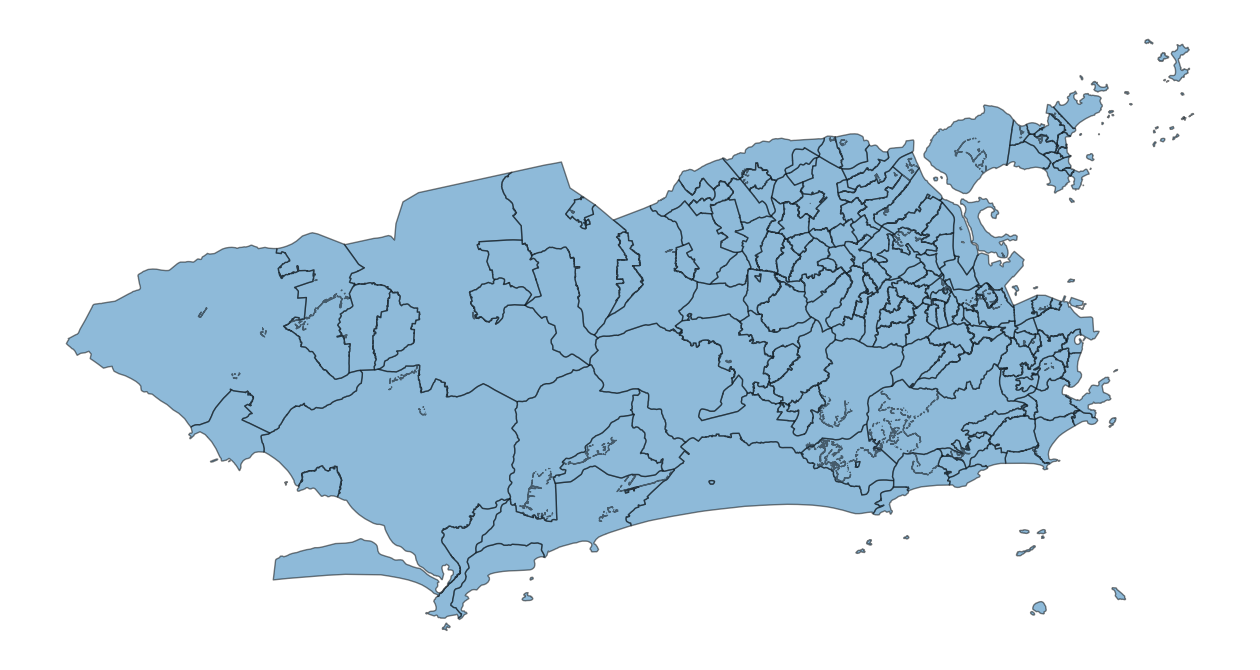

In [11]:

def plot_map(gdf, df, title, cmap = 'viridis', figsize=(16, 10)):
    ax = gdf.plot(figsize=figsize, alpha=0.5, edgecolor='k')
    # for i in gdf.index:
        # plt.text(
        #     gdf.geometry.centroid[i].coords[0][0], 
        #     gdf.geometry.centroid[i].coords[0][1], 
        #     gdf.NM_BAIRRO[i],
        #     fontsize=10, 
        #     horizontalalignment='center', 
        #     verticalalignment='center'
        # )
    ax.set_axis_off()
    plt.show()

plot_map(gdf_rio_unique, df_rio, 'População do Rio de Janeiro')

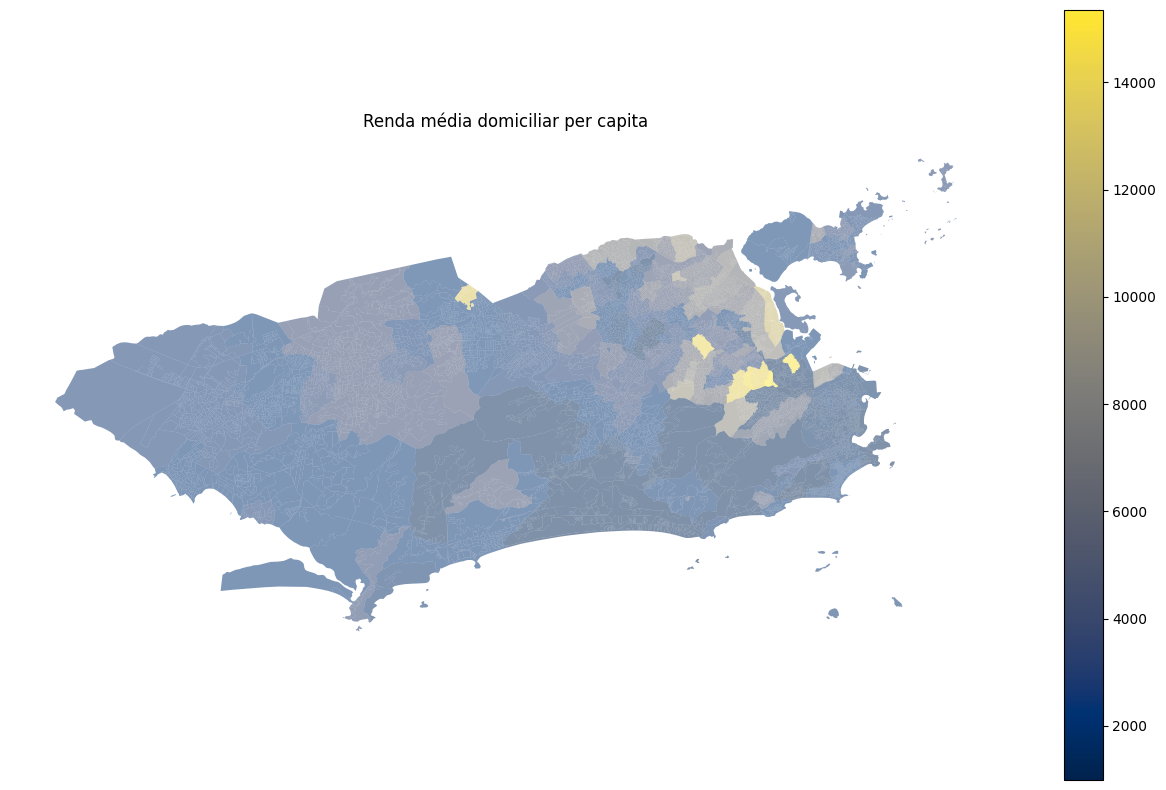

In [75]:
def plot_map(
        gdf, 
        column, 
        title, 
        cmap='viridis', 
        figsize=(16, 10)
    ):
    # Filter the GeoDataFrame to only the column of interest
    gdf = gdf[['geometry', column]]
    # Plot the GeoDataFrame
    ax = gdf.plot(
        column=column, 
        figsize=figsize, 
        alpha=0.5, 
        cmap=cmap, 
        # edgecolor='k', 
        legend=True
    )
    ax.set_axis_off()
    plt.title(title)
    plt.show()


plot_map(
    gdf_rio_bairros, 
    column='RENDIMENTO MENSAL DOMICILIAR EM JULHO DE 2010 ', 
    title='Renda média domiciliar per capita',
    cmap='cividis'
    )

In [54]:
df_rio_bairros.columns

Index(['ÁREA DE PONDERAÇÃO', 'NM_BAIRRO', 'geometry',
       'VALOR DO ALUGUEL (EM REAIS)             ',
       'ALUGUEL EM Nº DE SALÁRIOS MÍNIMOS ', 'CÔMODOS, NÚMERO',
       'DENSIDADE DE MORADOR/CÔMODO ', 'CÔMODOS COMO DORMITÓRIO, NÚMERO',
       'DENSIDADE DE MORADOR / DORMITÓRIO  ',
       'QUANTAS PESSOAS MORAVAM NESTE DOMICÍLIO EM 31 DE JULHO DE 2010',
       'RENDIMENTO MENSAL DOMICILIAR EM JULHO DE 2010 ',
       'RENDIMENTO DOMICILIAR, SALÁRIOS MÍNIMOS, EM JULHO DE 2010 ',
       'RENDIMENTO DOMICILIAR PER CAPITA EM JULHO DE 2010 ',
       'RENDIMENTO DOMICILIAR PER CAPITA, EM Nº DE SALÁRIOS MÍNIMOS, EM JULHO DE 2010 '],
      dtype='object')

In [45]:
df_rio_bairros.head()

,ÁREA DE PONDERAÇÃO,NM_BAIRRO,VALOR DO ALUGUEL (EM REAIS),ALUGUEL EM Nº DE SALÁRIOS MÍNIMOS,"CÔMODOS, NÚMERO",DENSIDADE DE MORADOR/CÔMODO,"CÔMODOS COMO DORMITÓRIO, NÚMERO",DENSIDADE DE MORADOR / DORMITÓRIO,QUANTAS PESSOAS MORAVAM NESTE DOMICÍLIO EM 31 DE JULHO DE 2010,RENDIMENTO MENSAL DOMICILIAR EM JULHO DE 2010,"RENDIMENTO DOMICILIAR, SALÁRIOS MÍNIMOS, EM JULHO DE 2010",RENDIMENTO DOMICILIAR PER CAPITA EM JULHO DE 2010,"RENDIMENTO DOMICILIAR PER CAPITA, EM Nº DE SALÁRIOS MÍNIMOS, EM JULHO DE 2010"
0,330455705001,Centro,327.799218,64274.442757,4.043308,7.986894,1.497733,21.319577,2.922845,1579.880703,3.097805e+05,61849.659970,121273.835187
81204,330455705002,Gamboa,1159.207010,227295.476830,5.980888,4.979840,1.754057,14.601856,2.391648,7155.431801,1.403026e+06,320324.371639,628087.028828
94056,330455705003,Santo Cristo,1233.967570,241954.440978,6.210603,3.912454,1.632087,13.216493,2.061717,8361.479891,1.639506e+06,474014.030264,929439.302544
102396,330455705004,Caju,343.910798,67433.581322,4.428008,7.195278,1.584195,19.718534,2.972907,2241.145152,4.394402e+05,96282.679136,188789.564055
115836,330455705005,Catumbi,295.536265,57948.378131,4.076830,7.346687,1.406174,21.284160,2.804895,1837.415127,3.602774e+05,81976.665193,160738.564219


<Axes: >

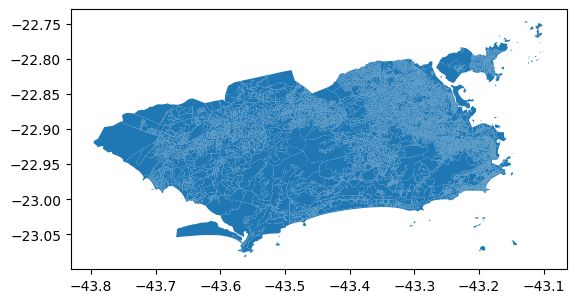

In [58]:
gp.GeoDataFrame(df_rio_bairros).plot()